# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [21]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [22]:
import torchvision.models as models
from tqdm import tqdm
from workspace_utils import active_session

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [23]:
data_dir = "cifar_10_data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"

In [24]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize(1024), #upscale so we have room to work
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224), #downscale to imagenet compatible size
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

valid_transforms = transforms.Compose([
    transforms.Resize(255), #upscale so we have room to work
    transforms.CenterCrop(224), #downscale to imagenet compatible size
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

test_transforms = transforms.Compose([
    transforms.Resize(255), #upscale so we have room to work
    transforms.CenterCrop(224), #downscale to imagenet compatible size
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.CIFAR10(root=train_dir, train=True, download=True, transform=train_transforms)
valid_dataset = torchvision.datasets.CIFAR10(root=valid_dir, train=True, download=True, transform=valid_transforms)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.seed(42)
np.random.shuffle(indices)
split = int(np.floor(0.8 * num_train))
train_indices, valid_indices = indices[:split], indices[split:]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, sampler=valid_sampler)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(root=test_dir, train=False, transform=test_transforms, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [16]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

deer


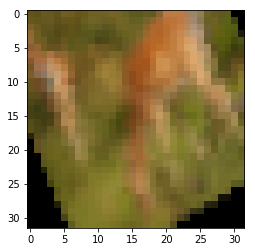

deer


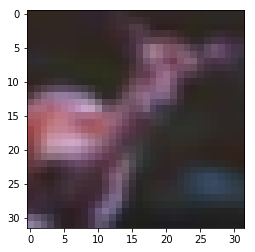

plane


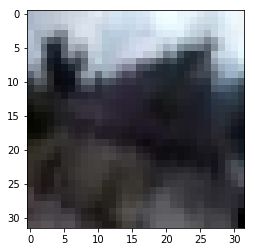

frog


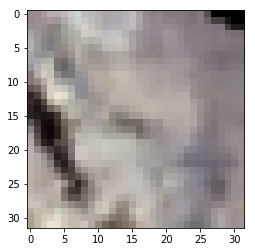

cat


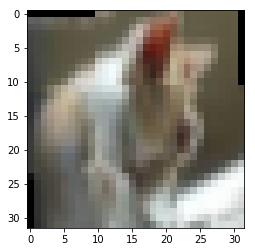

In [21]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [25]:
training_classifier = nn.Sequential(nn.Linear(1024,256),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(256, 10),
                                nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [26]:
device = "cuda"

training_model = models.densenet121(pretrained=True)

for param in training_model.parameters():
    param.requires_grad = False

training_model.classifier = training_classifier

training_model.to(device)

optimizer = optim.Adam(training_model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [27]:
def getFloatTensorType(device):
    return torch.FloatTensor if device == "cpu" else torch.cuda.FloatTensor

In [28]:
#set status
epochs_completed = 0

#set expectation
epochs_target = 5 # train until

#duration of this training session
epochs = epochs_target - epochs_completed

print("Epochs completed:{} targeted:{} training:{} ...".format(epochs_completed, epochs_target, epochs))
training_losses, validation_losses = [], []

with active_session(): #to keep vm workspace alive for more than 30 minutes
    for e in range(epochs):

        running_loss = 0

        for images, labels in tqdm(train_loader, desc="Train"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            log_ps = training_model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()        

        epochs_completed += 1
        validation_loss = 0
        validation_accuracy = 0
        floatTensorType = getFloatTensorType(device)

        training_model.eval()

        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Valid"):
                images, labels = images.to(device), labels.to(device)

                log_ps = training_model(images)
                loss = criterion(log_ps, labels)
                validation_loss += loss.item()
                ps = torch.exp(log_ps)
                top_ps, top_class = ps.topk(1, dim=1)
                correct = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(correct.type(floatTensorType))
                validation_accuracy += accuracy.item()

        training_model.train() 

        training_losses.append(running_loss/len(train_loader))
        validation_losses.append(validation_loss/len(valid_loader))
        print('E:{} Training Loss:{:.3f} Validation Loss:{:.3f} Accuracy:{:.3f}'.format(
            epochs_completed,
            running_loss/len(train_loader),
            validation_loss/len(valid_loader),
            100*(validation_accuracy/len(valid_loader))
            )
        )

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Epochs completed:0 targeted:5 training:5 ...


Train:   0%|          | 0/1250 [00:00<?, ?it/s]

E:1 Training Loss:1.448 Validation Loss:0.809 Accuracy:72.813


Train:   0%|          | 0/1250 [00:00<?, ?it/s]

E:2 Training Loss:1.288 Validation Loss:0.750 Accuracy:73.802


Train:   0%|          | 0/1250 [00:00<?, ?it/s]

E:3 Training Loss:1.246 Validation Loss:0.709 Accuracy:75.459


Train:   0%|          | 0/1250 [00:00<?, ?it/s]

E:4 Training Loss:1.238 Validation Loss:0.691 Accuracy:76.398


Valid: 100%|██████████| 313/313 [01:30<00:00,  4.03it/s]

E:5 Training Loss:1.229 Validation Loss:0.728 Accuracy:75.010


Plot the training loss (and validation loss/accuracy, if recorded).

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

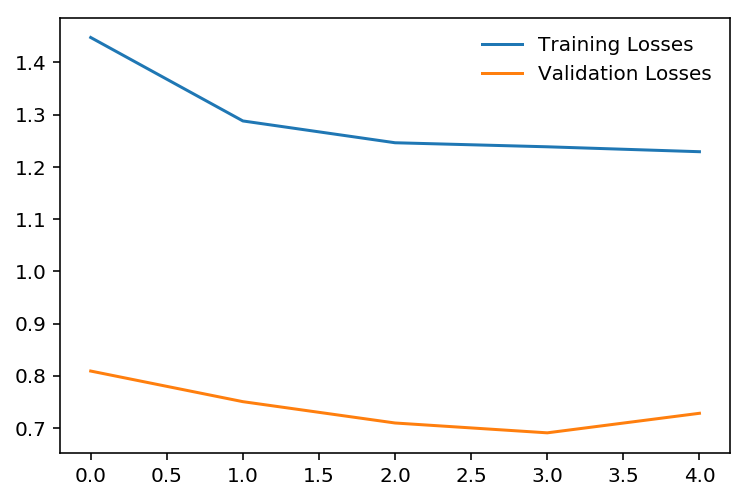

In [30]:
plt.plot(training_losses, label='Training Losses')
plt.plot(validation_losses, label='Validation Losses')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [31]:
device = 'cuda'
test_loss = 0
test_accuracy = 0
floatTensorType = getFloatTensorType(device)

training_model.to(device)
training_model.eval()
with torch.no_grad():
    #print("Validating a {}-epochs model on {} batches of size {}...".format(epochs_completed, len(validloader), validloader.batch_size))
    for images, labels in tqdm(test_loader, desc="Test"):
        images, labels = images.to(device), labels.to(device)

        log_ps = training_model(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        correct = top_class == labels.view(*top_class.shape)
        accuracy = torch.mean(correct.type(floatTensorType))
        test_accuracy += accuracy.item()

    #print("E:{} Test:{:.3f} Acc:{:.3f}".format(epochs_completed, test_loss/len(validloader), 100.0 * test_accuracy/len(validloader)))

training_model.train() 

print('E:{} Test Loss:{:.3f} Accuracy:{:.3f}'.format(
        epochs_completed,
        test_loss/len(test_loader),
        100*(test_accuracy/len(test_loader))
        )
    )

Test: 100%|██████████| 313/313 [01:30<00:00,  4.04it/s]

E:5 Test Loss:0.721 Accuracy:75.070


## Saving your model
Using `torch.save`, save your model for future loading.

In [32]:
def save_checkpoint(model, model_arch, optimizer, optimizer_learning_rate, epochs_completed, to_file_path):
    model.cpu()
    checkpoint = {
        'model_arch': model_arch,
        'model_classifier': model.classifier,
        'model_state_dict': model.state_dict(),
        'optimizer_learning_rate': optimizer_learning_rate,
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs_completed': epochs_completed
    }
    torch.save(checkpoint, to_file_path)

In [33]:
training_arch = 'densenet121'
training_lr = 0.001
training_hidden_units_count = 256
save_checkpoint(training_model, training_arch, optimizer, training_lr, epochs_completed,
                    'checkpoint_'+training_arch+'h'+str(training_hidden_units_count)+'e'+str(epochs_completed)+'.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

My model achieves over 75% accuracy, whereas Detectocorp's only has 70% accuracy.

My model achieves similar accuracy to the Deep Belief Networks from 2010.

I used transfer learning based on a DenseNet121 pre-trained model and replaced the final classifier with 256 hidden units, 0.2 drop out, a learning rate of 0.001, and 5 epochs of training to achieve over 75% accuracy.

My model's accuracy could be improved by training more epochs (perhaps 10, 15, or 20 epochs instead of 5).

Based on my evaluation, I recommend to build--not buy--a model because we can achieve over 75% accuracy in just 5 epochs of training based on a pre-trained DenseNet121 model with transfer learning.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).